# Demo: Gross Adjusted Income vs. Citibike Usage Analysis using Memento

In 2013, NYC launched its bike sharing program, Citibike, which is now an essential part of NYC's transportation infrastructure.

Is Citibike equitable? In covered areas, does it benefit individuals in wealthier neighborhoods more than others?

This notebook explores the following hypothesis which could be used, in part, to help answer this question. Specifically:

<b>Hypothesis: For covered areas, zip codes in NYC with higher median adjusted gross incomes show higher Citi Bike usage (trip starts + trip ends)</b>

There are several potential improvements that could be made to this hypothesis if we were conduting real research (e.g. some zip codes are larger than others), but the point of this notebook is to demonstrate how Memento might be used in a realistic research scenario.

<b>This is not a scientific analysis and is simply a demonstration of a typical research scenario and how Memento might be used to organize a notebook conducting similar research.</b>

<div style="font-size: 6pt;"><b>Disclaimer:</b>
<p>This document is being distributed for informational and educational purposes only and is not an offer to sell or the solicitation of an offer to buy any securities or other instruments. The information contained herein is not intended to provide, and should not be relied upon for, investment advice. The views expressed herein are not necessarily the views of Two Sigma Investments, LP or any of its affiliates (collectively, “Two Sigma”). Such views reflect the assumptions of the author(s) of the document and are subject to change without notice. The document may employ data derived from third-party sources. No representation is made by Two Sigma as to the accuracy of such information and the use of such information in no way implies an endorsement of the source of such information or its validity.</p>

<p>The copyrights and/or trademarks in some of the images, logos or other material used herein may be owned by entities other than Two Sigma. If so, such copyrights and/or trademarks are most likely owned by the entity that created the material and are used purely for identification and comment as fair use under international copyright and/or trademark laws. Use of such image, copyright or trademark does not imply any association with such organization (or endorsement of such organization) by Two Sigma, nor vice versa.</p>
</div>

## Init and Imports

In [ ]:
# sudo apt-get install graphviz
!pip install boto3 matplotlib geopy scipy twosigma.memento

In [2]:
from twosigma.memento import memento_function
import boto3
from io import BytesIO, StringIO
import zipfile
import pandas as pd
import matplotlib
import requests
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

## Citibike Trip Data

In [3]:
@memento_function
def ingest_citibike(year: int):
    bucket = "tripdata"
    s3_client = boto3.client("s3")
    zip_filename = f"{year}-citibike-tripdata.zip"
    response = s3_client.get_object(Bucket=bucket, Key=zip_filename)
    object_data = response['Body'].read()
    return object_data

In [4]:
def list_citibike_csvs(zip: zipfile.ZipFile) -> list[str]:
    return sorted([file for file in zip.namelist() if file.endswith("_1.csv")], key=lambda f: f[f.rindex("/")+1:])

In [5]:
@memento_function
def citibike_tripdata_csv(year: int, month: int) -> str:
    yyyymm = f"{year}{month:02}"
    data = ingest_citibike(year)
    zip = zipfile.ZipFile(BytesIO(data))
    name_list = list_citibike_csvs(zip)
    names_for_month = [name for name in name_list if yyyymm in name]
    if len(names_for_month) >= 1:
        name = names_for_month[0]
        with zip.open(name) as f:
            return f.read().decode("utf-8")
    else:
        return None


In [6]:
@memento_function
def normalize_citibike_tripdata(year: int, month: int = None) -> pd.DataFrame:
    if month is None:
        all_dfs = [normalize_citibike_tripdata(year, m) for m in range(1, 13)]
        all_dfs = [df for df in all_dfs if df is not None]
        return pd.concat(all_dfs)
    else:
        return pd.read_csv(StringIO(citibike_tripdata_csv(year, month)))

In [7]:
@memento_function
def zip_by_lat_long(lat: float, long: float) -> int:
  geolocator = Nominatim(user_agent="twosigma_memento_example")
  location = geolocator.reverse((lat, long))
  if location.raw.get('address', {}).get('postcode'):
    return location.raw['address']['postcode']
  else:
    return None

In [8]:
@memento_function
def start_usage(year: int) -> pd.DataFrame:
    df = normalize_citibike_tripdata(2020)
    df = df \
        .groupby("start station id") \
        .agg(
            count=("start station id", "size"),
            lat=("start station latitude", "first"),
            long=("start station longitude", "first")
        ) \
        .reset_index() \
        .drop("start station id", axis=1)
    
    # df is now (count, lat, long). Look up zip code
    df["zipcode"] = df.apply(lambda row: zip_by_lat_long(row["lat"], row["long"]), axis=1)
    return df


@memento_function
def end_usage(year: int) -> pd.DataFrame:
    df = normalize_citibike_tripdata(2020)
    df = df \
        .groupby("end station id") \
        .agg(
            count=("end station id", "size"),
            lat=("end station latitude", "first"),
            long=("end station longitude", "first")
        ) \
        .reset_index() \
        .drop("end station id", axis=1)
    
    # df is now (count, lat, long). Look up zip code
    df["zipcode"] = df.apply(lambda row: zip_by_lat_long(row["lat"], row["long"]), axis=1)
    return df


In [9]:
@memento_function
def citibike_activity_by_zip(year: int) -> pd.DataFrame:
    """Rides that started or ended in each zip code, over the course of the year"""
    df_start = start_usage(year)
    df_end = end_usage(year)
    d1 = df_start.drop(["lat", "long"], axis=1).groupby("zipcode").sum().reset_index()
    d2 = df_end.drop(["lat", "long"], axis=1).groupby("zipcode").sum().reset_index()
    d3 = d1.set_index("zipcode").add(d2.set_index("zipcode"), fill_value=0).reset_index()
    d3["zipcode"] = d3["zipcode"].astype(int)
    return d3

In [10]:
citibike_activity_by_zip.dependencies()

## IRS Data by Zip Code

In [11]:
@memento_function
def ingest_irs_gov_zip(year: int) -> bytes:
    url = f"https://www.irs.gov/pub/irs-soi/{year-2000}zpallnoagi.csv"
    response = requests.get(url)
    return response.content

In [12]:
@memento_function
def normalize_irs_gov_zip(year: int) -> pd.DataFrame:
    data = ingest_irs_gov_zip(year)
    csv = data.decode("utf-8")
    df = pd.read_csv(StringIO(csv))
    df.columns = [col.lower() for col in df.columns]
    return df

In [13]:
@memento_function
def irs_agi_per_person_by_zip(year: int) -> pd.DataFrame:
    """Compute mean AGI per person in each ZIP"""
    df = normalize_irs_gov_zip(year)
    # (a00100: AGI, n1: count)
    df["agi"] = df["a00100"] * 1000.0 / df["n1"]
    return df[["zipcode", "agi"]]

In [14]:
irs_agi_per_person_by_zip.dependencies()

## Join

In [15]:
@memento_function
def citibike_usage_and_agi_by_zip(year: int) -> pd.DataFrame:
    df_citibike = citibike_activity_by_zip(2020)    
    df_irs = irs_agi_per_person_by_zip(2020)
    df = df_citibike.rename(columns={"count": "citibike_usage"}).merge(df_irs, on="zipcode", how="inner")
    return df

In [16]:
citibike_usage_and_agi_by_zip.dependencies()

## Plot

In [17]:
df = citibike_usage_and_agi_by_zip(year=2020)

In [18]:
sorted_df = df.sort_values(by="agi")

In [19]:
sorted_df

,zipcode,citibike_usage,agi
52,10453,3834.0,30212.861510
56,10457,5217.0,31042.253137
55,10456,17924.0,31533.869116
60,10474,615.0,31624.716981
51,10452,13097.0,31659.843117
...,...,...,...
44,10065,258402.0,511061.425577
45,10069,116495.0,524012.461059
49,10282,154131.0,633103.517588
17,10013,356305.0,636092.180775


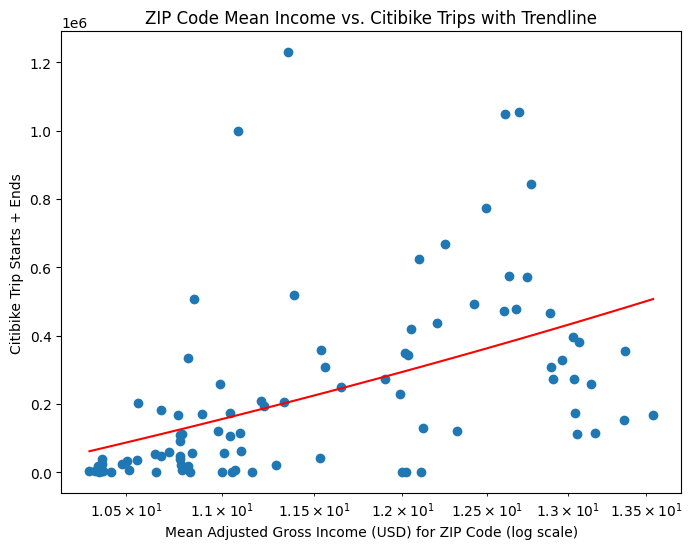

In [20]:
plt.figure(figsize=(8, 6))
x = np.log(sorted_df["agi"])
y = sorted_df["citibike_usage"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
trend_y = slope * x + intercept
plt.xscale('log') 
plt.scatter(x, y)
plt.plot(x, trend_y, color="red")
plt.xlabel("Mean Adjusted Gross Income (USD) for ZIP Code (log scale)")
plt.ylabel("Citibike Trip Starts + Ends")
plt.title("ZIP Code Mean Income vs. Citibike Trips with Trendline")
plt.show()

In [21]:
print(f"r^2: {r_value * r_value:0.3}\np_value: {p_value:0.3}\nstd_err: {std_err:0.3}")

r^2: 0.24
p_value: 6.41e-07
std_err: 2.58e+04


There is a weak but statistically significant positive correlation between zip code mean AGI and citibike trips started or ended in that zip code.

Citibike usage is statistically higher in neighborhoods with higher incomes, which could indicate that wealthier neighborhoods benefit from Citibike more.